In [1]:
# initial setup ###
import numpy as np
from vizdoom import *
import random

def create_environment():
    game = DoomGame()
    game.load_config('vizdoom/myConfig.cfg')  
    game.set_doom_scenario_path('vizdoom/square.wad')
    #game.set_doom_scenario_path('vizdoom/tmaze.wad')
    #game.set_doom_map('map01')
    game.set_mode(Mode.PLAYER)
    game.set_window_visible(False)
    game.set_automap_buffer_enabled(True)
    game.set_automap_mode(WHOLE)
    game.set_available_buttons([MOVE_LEFT, MOVE_RIGHT, MOVE_FORWARD, MOVE_BACKWARD, TURN_RIGHT]) 
    #game.set_available_buttons([MOVE_FORWARD, MOVE_BACKWARD, TURN_RIGHT, TURN_LEFT]) 
    game.set_available_game_variables([POSITION_X, POSITION_Y, ANGLE, VELOCITY_X, VELOCITY_Y, CAMERA_FOV])
    game.init()     
    return game

In [17]:
### plotting utilities ###
import matplotlib.pyplot as plt
from scipy import stats
import cv2

def plot_traj(traj, env_range=[(-200, 200), (-200, 200)]):
    #print((np.min(traj[:, 0]), np.max(traj[:, 0])));
    #print((np.max(traj[:, 1]), np.min(traj[:, 1])));
    plt.figure();
    plt.subplot(1, 1, 1);
    plt.plot(traj[:, 0], traj[:, 1], 'ko-');
    plt.xlim(env_range[0]);
    plt.ylim(env_range[1]);
    #plt.axis('off');
    plt.title('Trajectory');
    plt.show();
    
def compute_receptive_field(act, x, y, bin_size):
    # batch size and the number of neurons
    num_neuron = act.shape[0];
    # sampling size for gaussian smoothing
    sample_size = int(np.minimum(bin_size[0], bin_size[1]) / 4);
    if sample_size % 2 == 0 :
        sample_size += 1;
    
    # receptive field
    receptive_fields = np.zeros((num_neuron, bin_size[1], bin_size[0]));
    # compute receptive field with spatial position
    map_x = x.reshape(-1);
    map_y = y.reshape(-1);
    for neuron_idx in np.arange(num_neuron):
        f = act[neuron_idx, :].reshape(-1);
        ratemap, _, _, _ = stats.binned_statistic_2d(map_y, map_x, f, 
                                                     statistic = lambda x : np.mean(x),
                                                     bins = [bin_size[1], bin_size[0]]);
        # Nan value complete
        ratemap_nan = np.copy(ratemap);
        nan_idx = np.where(np.isnan(ratemap_nan));
        
        # gaussian sampling 
        ratemap_nan[nan_idx] = 0.0;
        ratemap_nan = cv2.GaussianBlur(ratemap_nan, (sample_size, sample_size), 0);
        ratemap[nan_idx] = ratemap_nan[nan_idx];
        receptive_fields[neuron_idx] = ratemap;
    return receptive_fields;

def plot_receptive_field(activity, traj, plot_size=[1,1], bin_length=30, fig_size=[15,15]):
    ratemaps = compute_receptive_field(activity, traj[:, 0], traj[:, 1], [int(traj[:, 0].size/bin_length), int(traj[:, 1].size/bin_length)]);
    num_neuron = ratemaps.shape[0];
    plt.figure(figsize=fig_size);
    #plt.axis('off');
    for neuron_idx in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0], plot_size[1], neuron_idx + 1);
        plt.imshow(ratemaps[neuron_idx], interpolation = 'gaussian');
    plt.show();

In [3]:
### self-motion (position) based grid-place system ###
# grid cells should receive self-motion input, but here we just build a simple model from position information
lambdaRange = (100, 300) #(28,73)

class MPlaceCell:
    def __init__(self, r0, sigma):
        self.data = []
        self.r0 = r0
        self.sigma = sigma
        
    def response(self, pos, record=True):
        res = np.exp(-((float(pos[0]-self.r0[0]))**2+(float(pos[1]-self.r0[1]))**2)/self.sigma**2)
        if record:
            self.data.append(res)
        return res
    
class MPCpopulation:
    def __init__(self, map_size, env_range, r0_range, sigma=50):
        nPC = map_size[0]*map_size[1]
        self.rw = np.zeros([nPC, nPC]) # recurrent weights
        self.cnt = 0
        
        useRand = True
        if useRand:
            r0x = np.random.rand(nPC) * (r0_range[0][1]-r0_range[0][0]) + np.ones((nPC)) * r0_range[0][0]
            r0y = np.random.rand(nPC) * (r0_range[1][1]-r0_range[1][0]) + np.ones((nPC)) * r0_range[1][0]
            r0s = np.array([r0x, r0y]).T
        else:
            r0s = []
            for i in range(map_size[0]):
                for j in range(map_size[1]):
                    r0s.append([r0_range[0][0]+i*(r0_range[0][1]-r0_range[0][0])/map_size[0], r0_range[1][0]+j*(r0_range[1][1]-r0_range[1][0])/map_size[1]])
        self.MPCs = [MPlaceCell(r0, sigma) for r0 in r0s]
    
    def trainHopfield(self, y):
        nNodes = len(self.MPCs)
        rw = np.matmul(y.reshape((1, -1)).T, y.reshape((1, -1)))
        mask = np.ones((nNodes, nNodes)) - np.identity(nNodes)
        rw = rw*mask
        self.rw = ( self.rw*self.cnt + rw/np.linalg.norm(rw.reshape(-1), axis=0) )/(self.cnt+1)
        self.cnt += 1
        
    def showRW(self):
        plt.figure();
        plt.imshow(self.rw);
        plt.show();
    
    def triggeredResponse(self, act):
        #print(np.max(act), np.max(self.rw), np.max(np.matmul(act.reshape((1, -1)), self.rw)))
        return np.matmul(act.reshape((1, -1)), self.rw)


In [9]:
### goal cell ###
class GoalCell:
    def __init__(self, nPC):
        self.nPC = nPC # number of place cells
        self.w = np.zeros(nPC)
        self.gc_max = 0
        self.data = []
    
    def response(self, PCact, record=False):
        res = np.dot(self.w, PCact)
        if record:
            self.data.append(res)
        return res
        
    def memorizeReward(self, PCact, PCpop, tRange = 50, decay = 0.8):
        # synapses from currently firing place cells are enhanced
        self.w += PCact/np.linalg.norm(PCact, axis=0)
        ripple = PCact/np.linalg.norm(PCact, axis=0)
        for t in range(tRange):
            ripple = PCpop.triggeredResponse(ripple).reshape(-1)
            ripple /= np.linalg.norm(ripple, axis=0)
            self.w +=  ripple * (decay**(t+1))
        self.w /= np.linalg.norm(self.w, axis=0)
        self.gc_max = self.response(PCact)
    
    def forget(self, factor=1000):
        self.w /= factor
        self.gc_max /= factor
        
def sim_gc(gc, PCpop, env_range, n, plot=True, bin_length=50, fig_size=[5,5]):
    def f(pos):
        return gc.response([pc.response(pos, False) for pc in PCpop.MPCs], False)
    return simulate_plot([f], env_range, n, plot, bin_length, fig_size)

def simulate_plot(funcs, env_range, n, plot=True, bin_length=50, fig_size=[15,15]):
    traj_x = np.random.rand(n) * (env_range[0][1]-env_range[0][0]) + np.ones((n)) * env_range[0][0]
    traj_y = np.random.rand(n) * (env_range[1][1]-env_range[1][0]) + np.ones((n)) * env_range[1][0]
    traj = np.array([traj_x, traj_y]).T
    
    activity = np.array([[func(pos) for pos in traj] for func in funcs])
    if plot:
        plot_receptive_field(activity, traj, plot_size=[int(len(funcs)**0.5), int(len(funcs)**0.5)], bin_length=bin_length, fig_size=fig_size)
    return traj, activity

In [85]:
### moving functions ###
    
def move(game, action, speed=1):
    game.make_action(action, speed)
    game.make_action([0]*game.get_available_buttons_size(), 100)
    return [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]

def randMove(game, avoidWall=False, speed=1):
    actions = np.identity(game.get_available_buttons_size(), dtype = int)
    mask = np.ones(game.get_available_buttons_size(), dtype=bool)
    if mask.size > 4:
        mask[4] = False # TURN_RIGHT
    if avoidWall:
        pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
        if pos[0] > 150:
            mask[2] = False # inhibit MOVE_FORWARD
        if pos[0] < -150:
            mask[3] = False # inhibit MOVE_BACKWARD
        if pos[1] > 150:
            mask[0] = False # inhibit MOVE_LEFT
        if pos[1] < -150:
            mask[1] = False # inhibit MOVE_RIGHT
    actions = actions[mask].tolist()
    action = random.choice(actions)
    return move(game, action, speed), action

def go_back_turn(game, ori_dir, speed=1):
    actions = np.identity(game.get_available_buttons_size(), dtype = int)
    if actions.size > 4:
        actions = np.delete(actions, 4, axis=0) #TURN_RIGHT
    opposite = ori_dir
    
    if ori_dir[0]:
        opposite[0] = 0
        opposite[1] = 1
        actions = np.delete(actions, 0, axis=0)
    elif ori_dir[1]:
        opposite[0] = 1
        opposite[1] = 0
        actions = np.delete(actions, 1, axis=0)
    elif ori_dir[2]:
        opposite[2] = 0
        opposite[3] = 1
        actions = np.delete(actions, 2, axis=0)
    elif ori_dir[3]:
        opposite[2] = 1
        opposite[3] = 0
        actions = np.delete(actions, 3, axis=0)
    
    return move(game, opposite, speed), random.choice(actions.tolist())

def initPos(game):
    # go to another initial position
    for i in range(100):
        randMove(game, True, 15)
    
def search(game, rewardPos, tolerance, MPCpop, gc):
    rewarded = False
    while not rewarded:
        randMove(game, True, random.randint(3,6))
        pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
        mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]
        if pos[0]>rewardPos[0]-tolerance and pos[0]<rewardPos[0]+tolerance and pos[1]>rewardPos[1]-tolerance and pos[1]<rewardPos[1]+tolerance: 
            print("reward! (random search)")
            rewarded = True
            gc.memorizeReward(np.array(mpc_activity), MPCpop, tRange=5, decay=0.1)
            #gc.response(mpc_activity) # record gc response

In [ ]:
### explicit strategy ###
    
def exploitation(game, MPCpop, gc, rewardPos, tolerance, nMoves=100):
    rewarded = False
    gc.data = []
    # random initial position
    pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
    traj = [pos]
    mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]
    gc_activity = gc.response(mpc_activity, True)
    
    speed = 1
    p = 0.01
    threshold_low = gc.gc_max*0.7
    threshold_high = gc.gc_max*0.95
    #print(threshold_low, threshold_high)
    pos, direction = randMove(game, True) # randomly decide a direction
    traj.append(pos)
    
    for i in range(nMoves):
        mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]
        #MPCpop.trainHopfield(np.array(mpc_activity))
        gc_activity = gc.response(mpc_activity, True)
        ori_pos = pos
    
        if gc_activity < threshold_high or len(gc.data) < 3:
            if gc_activity < threshold_low:
                #sys.stdout.write("fast ")
                speed = 5
            else:
                #sys.stdout.write("medium ")
                speed = 3
            
            if gc.data[-2] < gc_activity: # current position is better than the last; i.e. direction is good
                #sys.stdout.write("following gradient ")
                pos = move(game, direction, speed)
            else:
                #sys.stdout.write("going back and turn ")
                pos, direction = go_back_turn(game, direction, speed)
                pos = move(game, direction, speed)
        
        else:
            #sys.stdout.write("slow ")
            speed = 1
        
            if gc.data[-2] < gc_activity or gc.data[-3] < gc_activity: # current position is better than the last; i.e. direction is good
                #sys.stdout.write("following gradient ")
                pos = move(game, direction, speed)
            else:
                #sys.stdout.write("going back and turn ")
                pos, direction = go_back_turn(game, direction, speed)
                pos = move(game, direction, speed)
        
        traj.append(pos)
        #print(ori_pos, gc_activity)
        
        if pos[0]>rewardPos[0]-tolerance and pos[0]<rewardPos[0]+tolerance and pos[1]>rewardPos[1]-tolerance and pos[1]<rewardPos[1]+tolerance: 
            print("reward!", i)
            rewarded = True
            break
    if not rewarded:
        print("fail!")
    plot_traj(np.array(traj))
    return rewarded

def ratGo(game, MPCpop, gc, rewardPos, tolerance):
    if not exploitation(game, MPCpop, gc, rewardPos, tolerance, nMoves=100):
        # if failed to find the reward in nMoves, the rat believes the reward position has changed
        print("forget and search...")
        gc.forget()
        search(game, rewardPos, tolerance/1.5, MPCpop, gc)


In [89]:
### unified strategy ###
def unifiedStrategy(game, MPCpop, gc, rewardPos, tolerance):
    rewarded = False
    gc.data = []
    # initial position & responses
    pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
    traj = [pos]
    mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]
    gc_activity = gc.response(mpc_activity, True)
    
    speed = 1
    p = np.exp(-gc.gc_max) # possibility to random walk
    threshold_low = gc.gc_max*0.7
    threshold_high = gc.gc_max*0.95
    
    pos, direction = randMove(game, True) # randomly decide an initial direction
    traj.append(pos)
    
    while not rewarded:
        mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]
        gc_activity = gc.response(mpc_activity, True)
        ori_pos = pos
        
        if random.random() < p:
            pos, direction = randMove(game, avoidWall=True, speed=random.randint(3,6))
        else:
            if gc_activity < threshold_high or len(gc.data) < 3:
                if gc_activity < threshold_low:
                    #sys.stdout.write("fast ")
                    speed = 5
                else:
                    #sys.stdout.write("medium ")
                    speed = 3
                
                ##### far away -- random walk or follow gradient? #####
                
                if gc.data[-2] < gc_activity: # current position is better than the last; i.e. direction is good
                    #sys.stdout.write("following gradient ")
                    pos = move(game, direction, speed)
                else:
                    #sys.stdout.write("going back and turn ")
                    pos, direction = go_back_turn(game, direction, speed)
                    pos = move(game, direction, speed)
            
            else:
                #sys.stdout.write("slow ")
                speed = 1
            
                if gc.data[-2] < gc_activity or gc.data[-3] < gc_activity: # current position is better than the last; i.e. direction is good
                    #sys.stdout.write("following gradient ")
                    pos = move(game, direction, speed)
                else:
                    #sys.stdout.write("going back and turn ")
                    pos, direction = go_back_turn(game, direction, speed)
                    pos = move(game, direction, speed)
        
        traj.append(pos)
        #print(ori_pos, gc_activity, p)
        
        if pos[0]>rewardPos[0]-tolerance and pos[0]<rewardPos[0]+tolerance and pos[1]>rewardPos[1]-tolerance and pos[1]<rewardPos[1]+tolerance: 
            print("reward!", len(traj))
            rewarded = True
            gc.memorizeReward(np.array(mpc_activity), MPCpop, tRange=3, decay=0.1)
            break
        else:
            gc.forget(1.01) # gradually forget
            p = np.exp(-gc.gc_max)
            threshold_low = gc.gc_max*0.7
            threshold_high = gc.gc_max*0.95
        
        if len(traj) > 5000:
            print("fail!")
            break
    plot_traj(np.array(traj))

0 100 200 300 400 500 600 700 800 900 

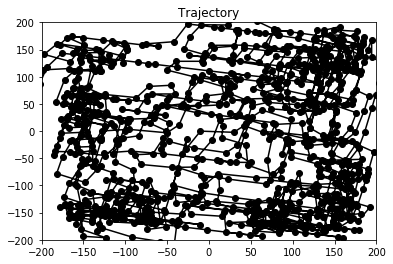

In [86]:
### initialize & exploration ###
import time
import scipy.io as sio
import sys
np.seterr(divide='ignore', invalid='ignore')

game = create_environment()
game.new_episode()
#cv2.imwrite('map.jpg', game.get_state().automap_buffer);

game.make_action([0, 0, 0, 0, 1], 10)
game.make_action([0, 0, 0, 0, 0], 100)
initial_state = game.get_state().screen_buffer
traj = []

## V1 ##
#v1 = V1(initial_state)

## MPC ##
env_range = [[-190, 190], [-190, 190]]
r0_range = [[-150, 150], [-150, 150]]
map_size = [15, 15]
nGrids = 10
MPCpop = MPCpopulation(map_size, env_range, r0_range, sigma=60)
        
## Goal Cell ##
gc = GoalCell(len(MPCpop.MPCs))

#random.seed(897)
# exploration
for i in range(1000):
    if i%100 == 0:
        sys.stdout.write(str(i)+' ')
    
    randMove(game, True, random.randint(3,6))
    pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
    traj.append(pos)
    #angle = float(game.get_game_variable(ANGLE)/game.get_game_variable(CAMERA_FOV))
    #v1_activity = v1.response(game.get_state().screen_buffer)
    mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]    
    MPCpop.trainHopfield(np.array(mpc_activity))
        
plot_traj(np.array(traj)) # check that exploration covers well


#time.sleep(1)
game.close()


new reward position: [29.858585162290154, -101.26698977488235]
reward! 2599


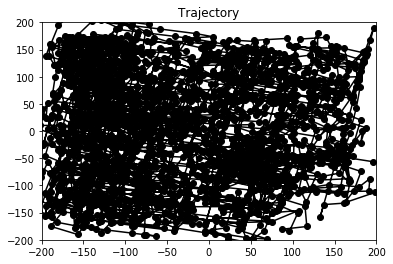

reward! 18


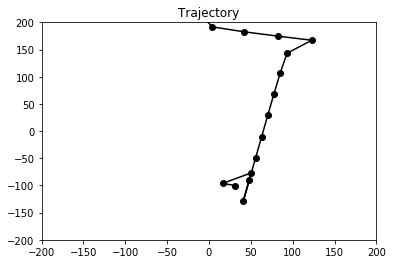

reward! 44


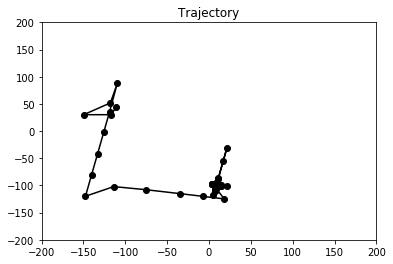

reward! 22


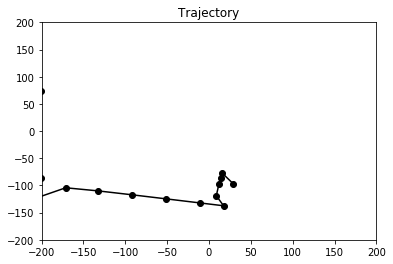

reward! 9


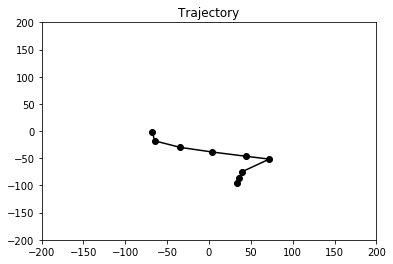

new reward position: [8.115433896172846, 41.954142910846286]
reward! 672


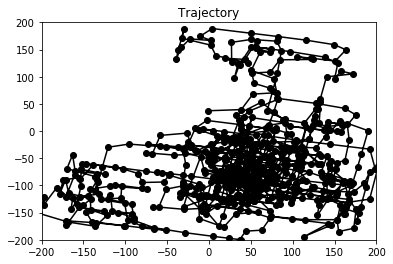

reward! 66


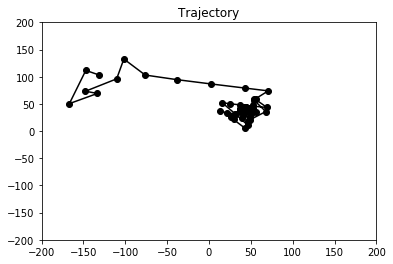

reward! 17


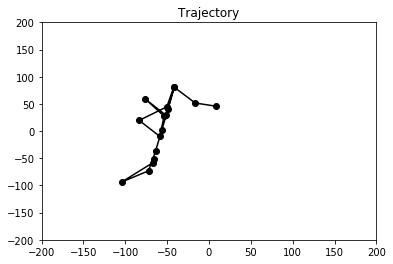

reward! 32


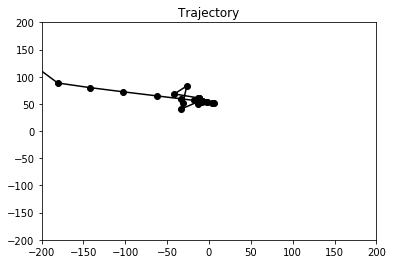

reward! 22


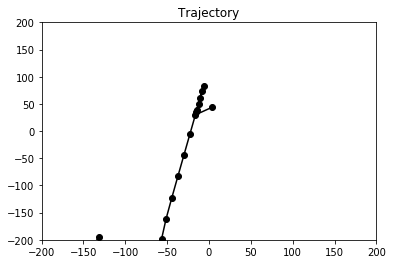

new reward position: [-114.34263721478824, -121.38323585039538]
reward! 295


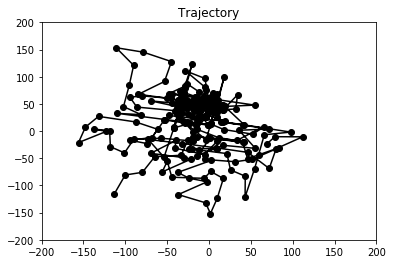

reward! 187


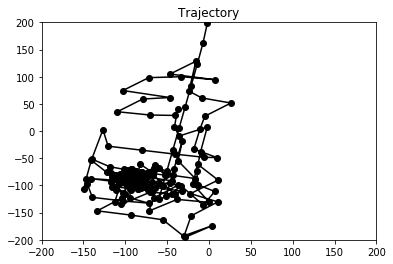

reward! 27


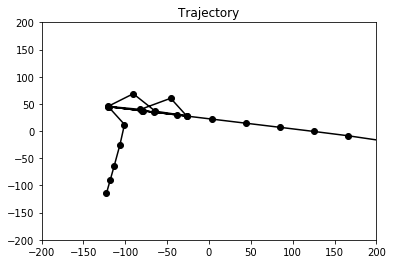

reward! 23


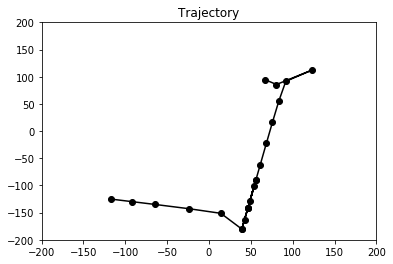

reward! 57


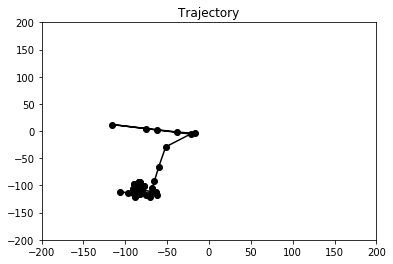

new reward position: [29.58048436409473, -116.72558993416334]
reward! 274


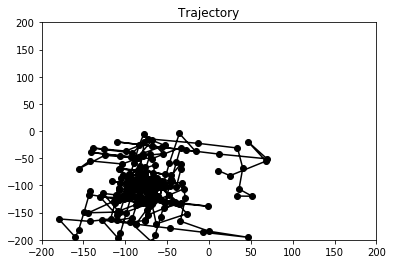

reward! 278


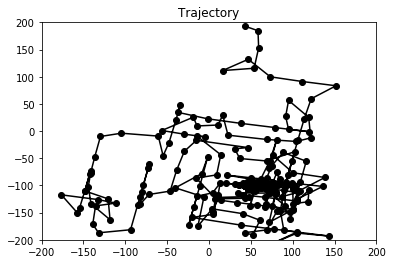

reward! 133


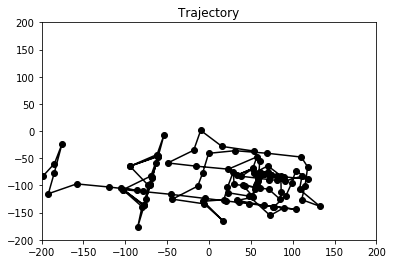

reward! 8


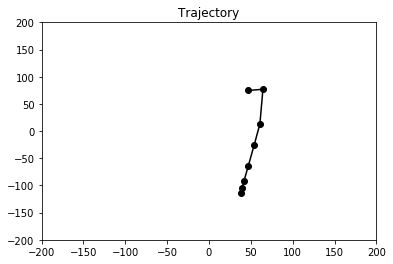

reward! 47


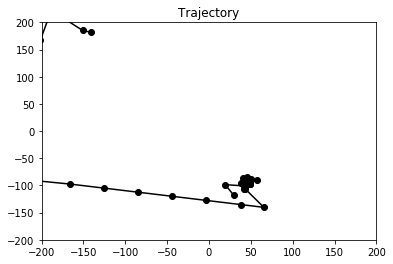

new reward position: [49.75509408898856, 57.32653463883247]
reward! 1108


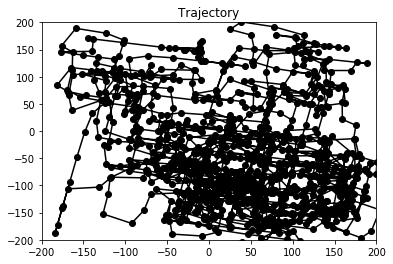

reward! 178


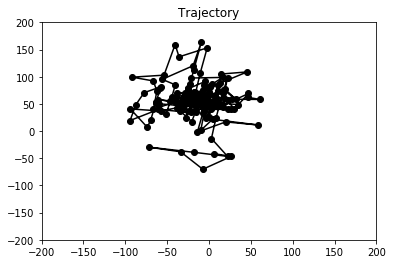

reward! 9


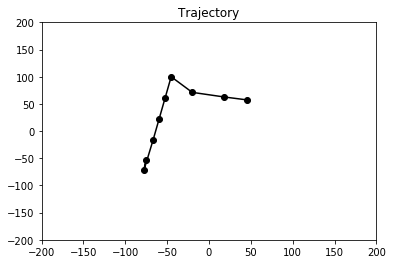

reward! 44


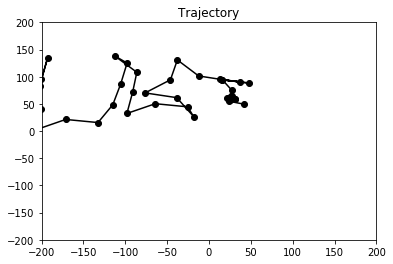

reward! 52


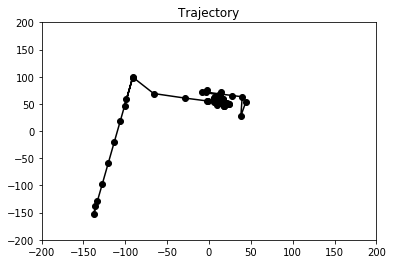

In [91]:
### testing/experiments ###

nExps = 5 # number of changing reward position
nTrails = 5 # number of testing of the same reward position

game = create_environment()
game.new_episode()
game.make_action([0, 0, 0, 0, 1], 10)
game.make_action([0, 0, 0, 0, 0], 10)

tolerance = 10
env_range = [[-130, 130], [-130, 130]]
for exp in range(nExps):
    rewardPos = [random.random() * (env_range[0][1]-env_range[0][0]) + env_range[0][0], random.random() * (env_range[1][1]-env_range[1][0]) + env_range[1][0]]
    print("new reward position:", rewardPos)
    for trial in range(nTrails):
        initPos(game)
        #sim_gc(gc, MPCpop, [[50, 150], [50, 150]], 1000, bin_length=40) #[[50, 150], [50, 150]]
        #ratGo(game, MPCpop, gc, rewardPos, tolerance)
        unifiedStrategy(game, MPCpop, gc, rewardPos, tolerance)
        
game.close()

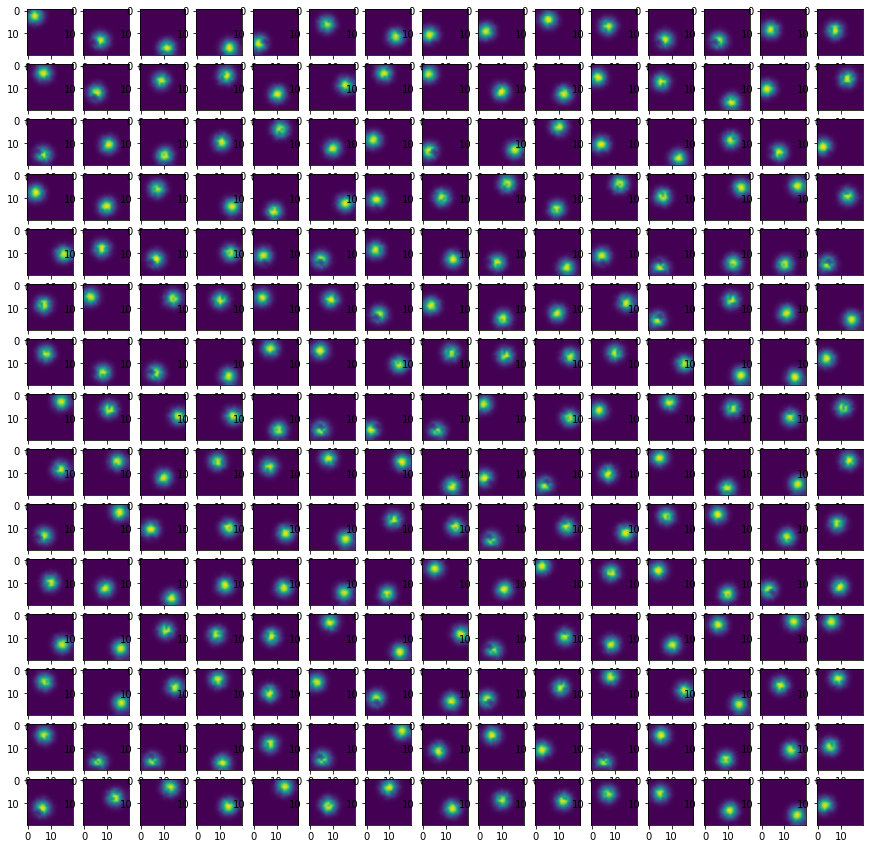

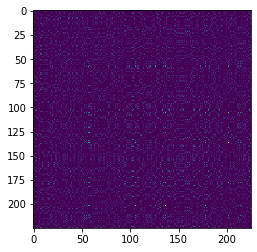

In [75]:
plot_receptive_field(np.array([mpc.data[:1000] for mpc in MPCpop.MPCs]), np.array(traj[:1000]), plot_size=map_size, bin_length=50)
#plot_receptive_field(np.array([gc.data[800:]]), trajectory[800: , :], plot_size=[1,1], bin_length=20, fig_size=[5, 5])
MPCpop.showRW()